<a href="https://colab.research.google.com/github/bunnysocks/DAv2-Finetuning/blob/main/BaselineModelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Install required packages
!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib numpy
!pip install timm  # For vision transformers

CUDA available: False
GPU: None


In [3]:
# Clone the Depth Anything v2 repository
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git
%cd Depth-Anything-V2

# Download pretrained weights (small model for Colab)
!wget https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth

# Add to Python path
import sys
sys.path.append('/content/Depth-Anything-V2')

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 142 (delta 31), reused 24 (delta 24), pack-reused 82 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 44.18 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/Depth-Anything-V2
--2025-11-09 17:17:02--  https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth
Resolving huggingface.co (huggingface.co)... 3.166.152.44, 3.166.152.105, 3.166.152.65, ...
Connecting to huggingface.co (huggingface.co)|3.166.152.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cas-bridge.xethub.hf.co/xet-bridge-us/666b17aaed1ed0f9bf42823e/01950a0198f6ece4acfd924dbc91f9f6bed4b614a222d64ad3c516ba39447464?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Credential=cas%2F20251109%2Fus-east-1%2Fs3%2Faws4_re

In [5]:
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 6.6 MB/s eta 0:00:00


In [6]:
from depth_anything_v2.dpt import DepthAnythingV2

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DepthAnythingV2(
    encoder='vits',  # Small version
    features=64,
    out_channels=[48, 96, 192, 384]
)

# Load pretrained weights
model.load_state_dict(torch.load('depth_anything_v2_vits.pth', map_location=device))
model = model.to(device)
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [9]:
import cv2
import numpy as np
from PIL import Image

def load_image(image_path, target_size=518):
    """Load and preprocess image for model"""
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, model needs RGB

    # Resize
    h, w = img.shape[:2]
    img = cv2.resize(img, (target_size, target_size))

    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0

    return img, (h, w)  # Return original size for later

# Test it
image_path="/content/Depth-Anything-V2/assets/examples/demo01.jpg"
test_img, orig_size = load_image(image_path)
print(f"Preprocessed shape: {test_img.shape}")
print(f"Original size: {orig_size}")

Preprocessed shape: (518, 518, 3)
Original size: (1362, 2048)


In [10]:
def predict_depth(model, image):
    """Run model inference"""
    # Convert to tensor
    img_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
    # Shape: (1, 3, 518, 518) = (batch, channels, height, width)

    img_tensor = img_tensor.to(device)

    # Predict
    with torch.no_grad():  # Disable gradient calculation (faster)
        depth = model(img_tensor)

    # Convert back to numpy
    depth = depth.squeeze().cpu().numpy()

    return depth

# Test prediction
depth_map = predict_depth(model, test_img)
print(f"Depth map shape: {depth_map.shape}")
print(f"Depth range: [{depth_map.min():.2f}, {depth_map.max():.2f}]")

Depth map shape: (518, 518)
Depth range: [0.00, 9.65]


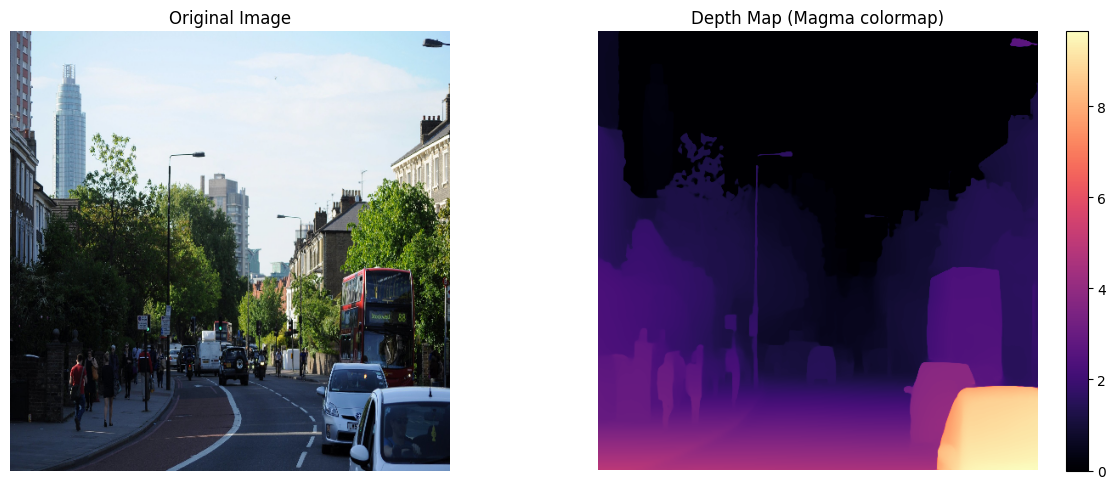

In [11]:
import matplotlib.pyplot as plt

def visualize_depth(image, depth):
    """Display original image and depth map side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Depth map (use colormap for better visualization)
    im = axes[1].imshow(depth, cmap='magma')
    axes[1].set_title('Depth Map (Magma colormap)')
    axes[1].axis('off')

    # Add colorbar
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    plt.tight_layout()
    plt.show()

# Visualize
visualize_depth(test_img, depth_map)